## Import libraries

In [1]:
import requests
import time
import datetime
import pandas as pd
from nltk.corpus import wordnet
import nltk
#nltk.download('wordnet')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

## Scrapping

In [2]:
#create timestamp for posts
d_end = datetime.date(2019,7,17)
unixtime_end = int(time.mktime(d_end.timetuple()))
d_start = datetime.date(2018,7,17)
unixtime_start = int(time.mktime(d_start.timetuple()))

In [3]:
diab_url = "https://api.pushshift.io/reddit/search/submission/?subreddit=diabetes&sort=desc&sort_type=created_utc&after={}&before={}&size=1000" .format(unixtime_start,unixtime_end)

In [4]:
cancer_url = "https://api.pushshift.io/reddit/search/submission/?subreddit=cancer&sort=desc&sort_type=created_utc&after={}&before={}&size=1000" .format(unixtime_start,unixtime_end)

In [5]:
class url_prep:
    
    def __init__(self, url):
        self.url = url   
    
    def request (self):
        headers ={"user-agent" :"Bleep blorp bot 0.2"}
        url_res = requests.get(self.url, headers=headers)
        self.json = url_res.json()
        self.key = sorted(url_res.json().keys())
        self.len = len(self.json["data"])

In [6]:
diab = url_prep(diab_url)
cancer = url_prep(cancer_url)

In [7]:
diseases = [diab,cancer]
for disease in diseases:
    disease.request()
    print(disease.key)
    print(disease.len)

['data']
1000
['data']
1000


In [8]:
diab.json["data"][0].keys() #to find out dict keys within data 

dict_keys(['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_text', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_richtext', 'link_flair_text_color', 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title', 'total_awards_received', 'updated_utc', 'url', 'whitelist_status', 'wls'])

## Data Cleaning

In [9]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return "Non English"
    else:
        return "English"

In [10]:
for disease in diseases:
    disease.title_data =[]
    disease.subreddit_data = []
    disease.type_data = []
    disease.content_data = []
    for i in range(disease.len):
        title =  disease.json["data"][i]["title"]
        disease.title_data.append (title)
        
        content =  disease.json["data"][i]["selftext"]
        disease.content_data.append (content)       
        
        
        subreddit =  disease.json["data"][i]["subreddit"]
        disease.subreddit_data.append (subreddit)
        
        word = isEnglish(disease.json["data"][i]["title"])
        disease.type_data.append (word)
        
        disease.data_posts = pd.DataFrame(disease.title_data, columns=["title"])
        disease.data_posts = disease.data_posts.join (pd.DataFrame(disease.content_data, columns=["content"]))
        disease.data_posts = disease.data_posts.join (pd.DataFrame(disease.subreddit_data, columns=["subreddit"]))
        disease.data_posts = disease.data_posts.join (pd.DataFrame(disease.type_data, columns=["type"]))
        disease.data_posts = disease.data_posts[disease.data_posts.type != 'Non English']
      

In [11]:
print (diab.data_posts.shape)
print (cancer.data_posts.shape)

(915, 4)
(921, 4)


In [12]:
frames = [diab.data_posts, cancer.data_posts]
data_finalposts = pd.concat(frames)

In [13]:
data_finalposts = data_finalposts [data_finalposts.content != ""]
data_finalposts['post_len'] = data_finalposts.content.map(lambda x: len(x.split()))
data_finalposts= data_finalposts[data_finalposts.post_len > 10]
data_finalposts= data_finalposts.drop(['type'],axis=1)

In [14]:
data_finalposts.content = data_finalposts.content.str.lower()
data_finalposts.content = data_finalposts.content.str.replace(r'[^\w\s]+', '')

In [15]:
data_finalposts.reset_index(drop=True, inplace=True)

## Classification Models

#### Engineer a feature to turn `subreddit types` into a 1/0 column, where 1 indicates `diabetes`.

In [16]:
data_finalposts["type"] = data_finalposts["subreddit"].replace(["diabetes","cancer"],[1,0])

In [17]:
X = data_finalposts.title
y = data_finalposts.type.ravel()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [19]:
class model_evaluation:
   
    def __init__(self, y_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        self.score = F1_score

#### Opt 1: Evaluate the performance of a Logistic Regression on the features extracted by the CountVectorizer

In [20]:
lrtext_clf = Pipeline([('vect', CountVectorizer()),
                     ('lr', LogisticRegression())])
lrtuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], #The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used
    'vect__stop_words': ["english"],
    'vect__analyzer': ["word"],
    'lr__solver': ["lbfgs"],
    'lr__C':[1,2,3]    
}

In [21]:
lr = GridSearchCV(lrtext_clf, lrtuned_parameters, cv=10)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test,predicted_lr)
lrg.confusion_matrix ()

True Negatives: 101
False Positives: 35
False Negatives: 18
True Positives: 149
Precision: 0.8097826086956522
Recall: 0.8922155688622755
F1 score: 0.8490028490028491


In [22]:
print('Best parameters: {}'.format(lr.best_params_))

Best parameters: {'lr__C': 1, 'lr__solver': 'lbfgs', 'vect__analyzer': 'word', 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


#### Opt 2: Fit a Multinomial Naive Bayes model wtih cvec!

In [23]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], #The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used
    'vect__stop_words': ["english"],
    'vect__analyzer': ["word"],
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [24]:
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(X_train, y_train)
predicted_nbcvec = clf.predict(X_test)
nbcvec = model_evaluation (y_test,predicted_nbcvec)
nbcvec.confusion_matrix ()

True Negatives: 108
False Positives: 28
False Negatives: 21
True Positives: 146
Precision: 0.8390804597701149
Recall: 0.874251497005988
F1 score: 0.8563049853372434


#### Opt 3: Fit a Multinomial Naive Bayes model with Tfid!

In [25]:
text_tclf = Pipeline([('Tvect', TfidfVectorizer()),
                     ('tclf', MultinomialNB())])
tuned_tparameters = {
    'Tvect__ngram_range': [(1, 1), (1, 2), (2, 2)], #The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used
    'Tvect__stop_words': ["english"],
    'Tvect__analyzer': ["word"],
    'tclf__alpha': [1, 1e-1, 1e-2]
}

In [26]:
tclf = GridSearchCV(text_tclf, tuned_tparameters, cv=10)
tclf.fit(X_train, y_train)
predicted_nbtvec = tclf.predict(X_test)
nbtvec = model_evaluation (y_test,predicted_nbtvec)
nbtvec.confusion_matrix ()

True Negatives: 107
False Positives: 29
False Negatives: 21
True Positives: 146
Precision: 0.8342857142857143
Recall: 0.874251497005988
F1 score: 0.8538011695906432


#### Summary

In [27]:
print ("F1 score - Logistic regression with cvec {}" .format(lrg.score))
print ("F1 score - Multinomial Naive Bayes model wtih cvec {}" .format(nbcvec.score))
print ("F1 score - Multinomial Naive Bayes model with Tfid  {}" .format(nbtvec.score))

F1 score - Logistic regression with cvec 0.8490028490028491
F1 score - Multinomial Naive Bayes model wtih cvec 0.8563049853372434
F1 score - Multinomial Naive Bayes model with Tfid  0.8538011695906432


## BONUS - SENTIMENT ANALYSIS 

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [29]:
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

In [30]:
for i in range(0, len(data_finalposts["content"])):
    vs_compound.append(analyzer.polarity_scores(data_finalposts["content"][i])['compound'])
    vs_pos.append(analyzer.polarity_scores(data_finalposts["content"][i])['pos'])
    vs_neu.append(analyzer.polarity_scores(data_finalposts["content"][i])['neu'])
    vs_neg.append(analyzer.polarity_scores(data_finalposts["content"][i])['neg'])

In [31]:
data_finalposts["vs_compound"]= pd.DataFrame(vs_compound)
data_finalposts["vs_pos"]= pd.DataFrame(vs_pos)
data_finalposts["vs_neu"]= pd.DataFrame(vs_neu)
data_finalposts["vs_neg"]= pd.DataFrame(vs_neg)

Text(0, 0.5, 'VADER Compound Sentiment Score')

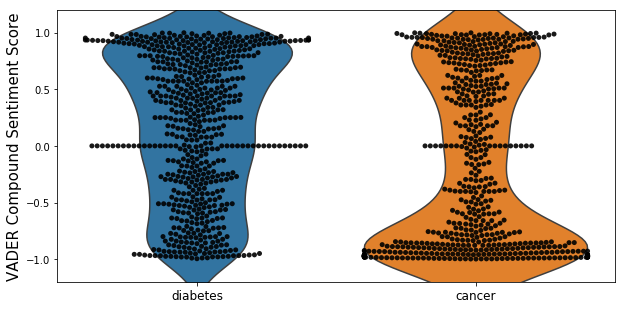

In [32]:
# plot 

x=data_finalposts["subreddit"]
y=data_finalposts["vs_compound"]

plt.close()
plt.figure(figsize=(10,5))
plt.ylim(-1.2,1.2)
sns.violinplot(x,y,inner=None)
sns.swarmplot(x,y, color="black", alpha=.9);
plt.xlabel('')
plt.xticks(size=12)
plt.ylabel('VADER Compound Sentiment Score',size=15)

In [33]:
data_finalposts["type"].value_counts()

1    625
0    584
Name: type, dtype: int64

In [34]:
data_finalposts.describe()

,post_len,type,vs_compound,vs_pos,vs_neu,vs_neg
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,135.323408,0.516956,-0.005997,0.096692,0.809644,0.093656
std,126.406447,0.499919,0.714918,0.066686,0.091673,0.072996
min,11.000000,0.000000,-0.998900,0.000000,0.421000,0.000000
25%,57.000000,0.000000,-0.780000,0.052000,0.750000,0.037000
50%,99.000000,1.000000,0.000000,0.089000,0.811000,0.085000
75%,168.000000,1.000000,0.718400,0.134000,0.872000,0.138000
max,1187.000000,1.000000,0.999200,0.551000,1.000000,0.465000


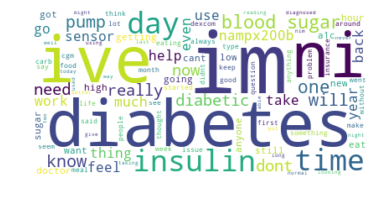

In [35]:
#top words for diabetes
top_diab = []
data_finalposts.sort_values(["type"], ascending=False, inplace=True)
for i in range(624):
    top_diab.append(data_finalposts['content'].values[i])

text_1 = str(top_diab)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

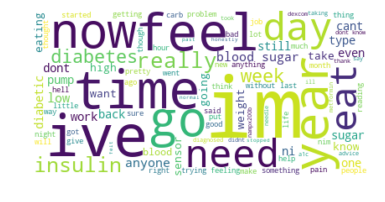

In [36]:
#collating top negative posts for diabets
diab_low = []
data_finalposts.sort_values(["type","vs_neg"], ascending=[False,False], inplace=True)
for i in range(100):
    diab_low.append(data_finalposts['content'].values[i])
text_2 = str(diab_low)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
#top5 verbatims
data_finalposts.sort_values(["type","vs_neg"], ascending=[False,False], inplace=True)
for i in range(5):
    print(data_finalposts['content'].values[i])
    print('-'*80)

do anybody else suffer from erectile dysfunction and do you think its related to your diabetes
--------------------------------------------------------------------------------
trying to lose weight but as you can imagine its difficult without proper knowledge the internet isnt so helpful does anyone have any advice or tips
--------------------------------------------------------------------------------
im 26 110 pounds and active and was just diagnosed with type 2 this year was talking about it with a coworker this week and she hit me with the question above didnt think itd phase me but man that shit is annoying someone insinuating even by accident that i could have prevented this pain in the ass disease that came at me out of nowhere one day and has changed my life forever sucks thats all
--------------------------------------------------------------------------------
im a genetic mess you guys ive likely had endometriosis since i was 13 symptomatic but not positively idd until 19 my 

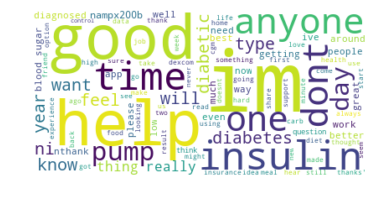

In [38]:
#collating top positive posts for diabetes
diab_high = []
data_finalposts.sort_values(["type","vs_pos"], ascending=[False,False], inplace=True)
for i in range(99):
    diab_high.append(data_finalposts['content'].values[i])
text_3 = str(diab_high)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_3)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
#top5 verbatims
data_finalposts.sort_values(["type","vs_pos"], ascending=[False,False], inplace=True)
for i in range(10):
    print(data_finalposts['content'].values[i])
    print('-'*80)

please email me if interested wjpadgett100gmailcommailtowjpadgett100gmailcom  buyer responsible for postage  thank you
--------------------------------------------------------------------------------
type 1 or type 2 need a day to day support systempartnerguide to help you improve or simply get through the daily grind let me know and ill do my best to help currently supporting type 1 and type 2 diabetics with emotional support diet support and insulin regimen support its hard to do this alone and hard to know where to start let me help
--------------------------------------------------------------------------------
i just wanted to share that my second hba1c since diagnosis 11 months ago came back as 56 im so happy i understand im probably still honeymooning but nevertheless very pleased with the result good much to the rest of you as well
--------------------------------------------------------------------------------
anyone have any luck getting the g6 app to work on non supported an

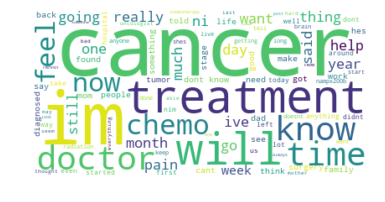

In [40]:
#top words for cancer
top_cancer = []
data_finalposts.sort_values(["type"], ascending=True, inplace=True)
for i in range(583):
    top_cancer.append(data_finalposts['content'].values[i])

text_4 = str(top_cancer)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_4)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

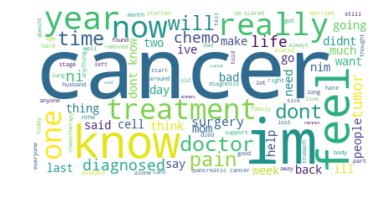

In [41]:
#collating top neg for cancer
cancer_low = []
data_finalposts.sort_values(["type","vs_neg"], ascending=[True,False], inplace=True)
for i in range(99):
    cancer_low.append(data_finalposts['content'].values[i])
text_5 = str(cancer_low)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_5)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
#top5 verbatims
data_finalposts.sort_values(["type","vs_neg"], ascending=[True,False], inplace=True)
for i in range(5):
    print(data_finalposts['content'].values[i])
    print('-'*80)

i fucking hate this had my last chemo friday yay  but shit i hate this hung over shaky feeling i hate coming off the steroids and i hate that my shit burns like life i hate that im so tired all i want to do is lie in bed and wait for it to pass im so tired i want my life back i want to feel normal again im so tired
--------------------------------------------------------------------------------
i it possible to give cancer a cancer of its own on that attacks only cancer cells 

call me fabio est toronto canada if it works
--------------------------------------------------------------------------------
sister had full remission of her cancer after months of chemo now the cancer is back again and worst than before absolutely gutted
--------------------------------------------------------------------------------
my question is statistically what are the percentages of cancer survivors whos cancer goes into remission  and then the cancer never returns and they die of old age or natural cau

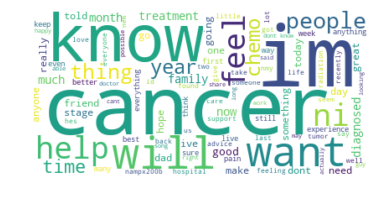

In [43]:
#collating top posts with high sentiment score for cancer
cancer_high = []
data_finalposts.sort_values(["type","vs_pos"], ascending=[True,False], inplace=True)
for i in range(99):
    cancer_high.append(data_finalposts['content'].values[i])
text_6 = str(cancer_high)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_6)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
#top5 verbatims
data_finalposts.sort_values(["type","vs_pos"], ascending=[True,False], inplace=True)
for i in range(10):
    print(data_finalposts['content'].values[i])
    print('-'*80)

my friend is finishing her last week of radiation and is very excited to start growing back her hair id like to make her a hair care package to help celebrate any products you can recommend
--------------------------------------------------------------------------------
specifically cervical but any stage 2 or greater long term surviving
--------------------------------------------------------------------------------
i finished chemo and radio today after doing them both at the same time

it feels bloody great and i hope youre all having a great day
--------------------------------------------------------------------------------
i never posted anything but me about 7 months ago the doctor thought my husbands cancer was back i would came here and read it help me a lot we finally found out he was crohms disease i got hungry for the first time in 7 months lol thanks to everyone who shared his story it helps a lot to know we are not alone i pray for all of you and your love ones thanks for